## Restaurant review classification

In [1]:
import tensorflow as tf
import numpy as np 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)
dataset

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [3]:
y = dataset['Liked'].values
y.shape

(1000,)

In [4]:
dataset['Review'][0]

'Wow... Loved this place.'

### Data preparation

In [5]:
import re
corpus = []
for i in range(0, 1000):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    review = review.lower()
    #review = review.split()
    corpus.append(review)
    
corpus[:5]

['wow    loved this place ',
 'crust is not good ',
 'not tasty and the texture was just nasty ',
 'stopped by during the late may bank holiday off rick steve recommendation and loved it ',
 'the selection on the menu was great and so were the prices ']

### First approach - LSTM's

In [6]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'the': 1, 'and': 2, 'i': 3, 'was': 4, 'a': 5, 'to': 6, 'is': 7, 'it': 8, 'this': 9, 'of': 10, 'food': 11, 'not': 12, 'for': 13, 'in': 14, 'place': 15, 't': 16, 'good': 17, 'we': 18, 'service': 19, 'very': 20, 'my': 21, 'with': 22, 'great': 23, 'had': 24, 'that': 25, 'be': 26, 'so': 27, 'you': 28, 'were': 29, 'are': 30, 'but': 31, 'have': 32, 'back': 33, 'they': 34, 'here': 35, 'on': 36, 'at': 37, 'like': 38, 'go': 39, 'all': 40, 'time': 41, 's': 42, 'our': 43, 'will': 44, 'there': 45, 'as': 46, 'really': 47, 'just': 48, 'an': 49, 'their': 50, 'if': 51, 'best': 52, 'would': 53, 'ever': 54, 'also': 55, 'friendly': 56, 'up': 57, 'only': 58, 'never': 59, 'one': 60, 'don': 61, 'no': 62, 'your': 63, 'restaurant': 64, 'out': 65, 'nice': 66, 'been': 67, 'what': 68, 'amazing': 69, 'again': 70, 'can': 71, 'from': 72, 'delicious': 73, 've': 74, 'vegas': 75, 'did': 76, 'by': 77, 'which': 78, 'm': 79, 'pretty': 80, 'some': 81, 'me': 82, 'came': 83, 'when': 84, 'experience': 

In [7]:
for line in corpus[0:10]:
    token_list = tokenizer.texts_to_sequences([line])[0]
    print(token_list)


[421, 167, 9, 15]
[578, 7, 12, 17]
[12, 153, 2, 1, 422, 4, 48, 423]
[579, 77, 291, 1, 580, 292, 880, 881, 182, 882, 883, 424, 2, 167, 8]
[1, 168, 36, 1, 111, 4, 23, 2, 27, 29, 1, 169]
[142, 3, 260, 202, 884, 2, 3, 132, 21, 346, 261]
[885, 8, 133, 16, 134, 25, 123]
[1, 425, 29, 38, 886, 2, 28, 107, 262, 34, 24, 67, 102, 57, 887, 10, 41, 124, 293, 426, 5, 888]
[1, 183, 29, 23, 112]
[5, 23, 581]


In [8]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    input_sequences.append(tokenizer.texts_to_sequences([line])[0])
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences.shape

(1000, 32)

In [9]:
input_sequences

array([[  0,   0,   0, ..., 167,   9,  15],
       [  0,   0,   0, ...,   7,  12,  17],
       [  0,   0,   0, ...,   4,  48, 423],
       ...,
       [  0,   0,   0, ...,  12,  39,  33],
       [  0,   0,   0, ..., 139, 161,  41],
       [  0,   0,   0, ..., 343,   1, 248]])

In [10]:
# Hyperparameters
embedding_dim = 64
lstm_units = 64
learning_rate = 0.001

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len),
          #Bidirectional(LSTM(lstm_units)),
          LSTM(lstm_units),
          Dense(1, activation='sigmoid')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 64)            129472    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 162,561
Trainable params: 162,561
Non-trainable params: 0
_________________________________________________________________


In [11]:
tf.keras.backend.clear_session()

epochs = 10

# Train the model
history = model.fit(input_sequences, y, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 3s 19ms/step - loss: 0.6884 - accuracy: 0.5390
Epoch 2/10
32/32 [==============================] - 1s 19ms/step - loss: 0.5859 - accuracy: 0.7680
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.3404 - accuracy: 0.8920
Epoch 4/10
32/32 [==============================] - 1s 18ms/step - loss: 0.1787 - accuracy: 0.9490
Epoch 5/10
32/32 [==============================] - 1s 19ms/step - loss: 0.1069 - accuracy: 0.9770
Epoch 6/10
32/32 [==============================] - 1s 19ms/step - loss: 0.0645 - accuracy: 0.9840
Epoch 7/10
32/32 [==============================] - 1s 18ms/step - loss: 0.0452 - accuracy: 0.9920
Epoch 8/10
32/32 [==============================] - 1s 18ms/step - loss: 0.0375 - accuracy: 0.9910
Epoch 9/10
32/32 [==============================] - 1s 18ms/step - loss: 0.0272 - accuracy: 0.9970
Epoch 10/10
32/32 [==============================] - 1s 19ms/step - loss: 0.0350 - accuracy: 0.9900


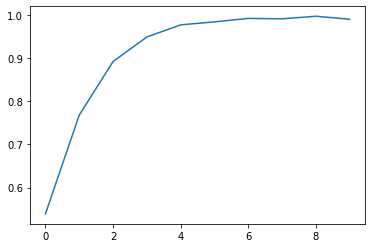

In [12]:
plt.plot(history.history['accuracy'])

In [13]:
test_sent = tokenizer.texts_to_sequences(['The service was awesome'])
test_sent

[[1, 19, 4, 152]]

In [14]:
test_padded = np.array(pad_sequences(test_sent, maxlen=max_sequence_len, padding='pre'))
test_padded

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,  19,   4, 152]])

In [15]:
model.predict(test_padded)[0][0]

0.9769362

### Second approach - bag of words

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [17]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [18]:
X,y = dataset.Review, dataset.Liked
X.values[:10]

array(['Wow... Loved this place.', 'Crust is not good.',
       'Not tasty and the texture was just nasty.',
       'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.',
       'The selection on the menu was great and so were the prices.',
       'Now I am getting angry and I want my damn pho.',
       "Honeslty it didn't taste THAT fresh.)",
       'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.',
       'The fries were great too.', 'A great touch.'], dtype=object)

In [19]:
Vectorizer = CountVectorizer()
count= Vectorizer.fit_transform(X.values)

In [20]:
count.toarray().shape

(1000, 2035)

In [21]:
X_train , X_test, y_train , y_test = train_test_split(count,y, test_size=0.25)

In [22]:
X_train.toarray().shape

(750, 2035)

In [23]:
NBclass = MultinomialNB()
NBclass.fit(X_train, y_train.values)

MultinomialNB()

In [24]:
y_pred = NBclass.predict(X_test)

In [25]:
y_pred

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [26]:
confusion_matrix(y_test , y_pred)

array([[ 96,  23],
       [ 27, 104]], dtype=int64)

In [27]:
accuracy_score(y_test , y_pred)

0.8

Since the order of words is important to know if the review is good or bad, LSTM's produce better results than bag-of-words approach